# Information
## Source
This notebook prepares the data from Lawley et al. (2022) using the version from https://drive.google.com/file/d/1jyxbPmwhMEhgezxMTxwmKTuU1PhT9yPe using the original H3 hexagonal polygon data.

**Citaton**: <p>
Christopher J.M. Lawley, Anne E. McCafferty, Garth E. Graham, David L. Huston, Karen D. Kelley, Karol Czarnota, Suzanne Paradis, Jan M. Peter, Nathan Hayward, Mike Barlow, Poul Emsbo, Joshua Coyan, Carma A. San Juan, Michael G. Gadd: <br>
Data–driven prospectivity modelling of sediment–hosted Zn–Pb mineral systems and their critical raw materials. <br>
Ore Geology Reviews, Volume 141, 2022, 104635, ISSN 0169-1368, https://doi.org/10.1016/j.oregeorev.2021.104635.

## What is it for?
This notebook contains the functionality to prepare and export the datacube data of a given model into a ML readable format.<br>

## How to
1. Get the datacube from the link above and extract the .csv file. In this notebook, we use *data/LAWLEY22-RAW*.<p>
2. Read the *Model setup* section<p>
3. Choose the preferred model from the Lawley et al. (2022) paper. Since we're working with the MVT, the definition is based on the **preferred** MVT model from the paper. <br>Your'e welcome to add other models in the <code>model.py</code> as you want to. The notebook will consider all **keys** with a **True** value, but not those with a **False** one. This way, it's easy to change exports as desired.<p>
4. Make some **user-defined** decisions and adjust path names etc. if necessary. <p>**ALL** possible user-interactions are in uppercase-letters.<br>The only point not considered here are the **Training** columns which may need some change if you want to export data for a **CD** model. You can do so down below in the **ground truth** investigation cells. Simply change *Training_MVT* to *Training_CD* if necessary.<p>
**We have to mention, that the generation of proxies like distance calculations, first and second order derivatives etc. will not work correctly with a geopgraphic CRS**.
5. Check the content of the datacube within the **Data** section.<p>
6. Prepare the data
    - numerical
    - categorical
    - ground truth data<p>
7. ...


## Model setup

Note that the **Geology_Dictionary** categories contain more than the incorporated dictionaries. Lawley et al. (2022) explicitly stated that:
- Sedimentary dictionaries = FineClastic, Carbonaceous, Calcareous
- Igneous dictionaries = Felsic, Intermediate, Mafic, Ultramafic
- Metamorphic dictionaries = Anatectic, Gneissose, Schistose

However, the complete list would be like:
- Sedimentary dictionaries = FineClastic, Carbonaceous, Calcareous, **Cherty, CoarseClastic, Evaporitic, RedBed, Sedimentary**
- Igneous dictionaries = Felsic, Intermediate, Mafic, Ultramafic, **Alkalic, Pegmatitic**
- Metamorphic dictionaries = Anatectic, Gneissose, Schistose

Also note, that the **Mafic** dictionary **does not exist** as separate column in the datacube and thus was not considered in the model setup! <br>
However, it seems to be included in the <i>Geology_Dictionary_UltramaficMafic</i> dict.

In [4]:
# Standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sys, os, warnings

from pathlib import Path

# Insert the path to the root directory of the project
if sys.version_info < (3, 9):
    from importlib_resources import files
else:
    from importlib.resources import files

sys.path.insert(0, str(Path(os.getcwd()).parent.parent))

# Custom modules
import beak.utilities.io as io                   
import beak.utilities.eda as eda
from beak.models import mvt_nat                   # Includes the model definitions used in this notebook 

BASE_PATH = files("beak.data")

# Definitions
**User inputs**

In [19]:
# Choose model
MODEL = "MVT_BASELINE"

# Path to datacube and export folder
PATH_DATACUBE_IN = BASE_PATH / "LAWLEY22-RAW/2021_Table04_Datacube.csv"

FORMAT = "FEATHER"                                  # FEATHER, CSV

# ROI
REGIONS =["United States of America", "Canada"]     # Canada, United States of America, Australia
N_ROWS = None                                       # Number of rows to read from datacube, None for all

COL_GROUND_TRUTH_MAX = "Training_MVT"
COLS_GROUND_TRUTH_DATACUBE = ["Training_MVT_Deposit", "Training_MVT_Occurrence"]
COLS_GROUND_TRUTH = [COL_GROUND_TRUTH_MAX] + COLS_GROUND_TRUTH_DATACUBE

ground_truth_selected = COL_GROUND_TRUTH_MAX


In [20]:
# Path variables
datacube = Path(PATH_DATACUBE_IN)
feather = Path(os.path.join(os.path.dirname(PATH_DATACUBE_IN), os.path.basename(PATH_DATACUBE_IN).split(".")[0] + ".feather"))

# Relevant columns for choosen model (considering only True values)
model = mvt_nat.models[MODEL]
model_columns = [key for key, value in model.items() if value == True]

# Allow only 3 decimals in DataFrame view
pd.options.display.float_format = "{:.3f}".format

# Set column to filter by region
region_column = "Country_Majority"
selected_columns = COLS_GROUND_TRUTH_DATACUBE + model_columns + [region_column]

# Show selected evicence layers
for i, layer in enumerate(model_columns):
  print(f"Evidence layer {i+1}/{len(model_columns)}: {layer}")
  

Evidence layer 1/12: Gravity_GOCE_ShapeIndex
Evidence layer 2/12: Gravity_Bouguer
Evidence layer 3/12: Gravity_Bouguer_HGM
Evidence layer 4/12: Gravity_Bouguer_UpCont30km_HGM
Evidence layer 5/12: Gravity_Bouguer_HGM_Worms_Proximity
Evidence layer 6/12: Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity
Evidence layer 7/12: Magnetic_HGM
Evidence layer 8/12: Magnetic_LongWavelength_HGM
Evidence layer 9/12: Magnetic_HGM_Worms_Proximity
Evidence layer 10/12: Magnetic_LongWavelength_HGM_Worms_Proximity
Evidence layer 11/12: Seismic_LAB_Hoggard
Evidence layer 12/12: Seismic_Moho


# Data

## **Load** data from csv or feather

In [21]:
# Convert to feather format if chosen
if FORMAT == "CSV" and datacube.exists():
  print("Loading datacube...")
  df = io.load_dataset(datacube, nrows=N_ROWS)
elif FORMAT == "FEATHER" and feather.exists():
    print("Loading feather...")
    df = io.load_feather(feather, columns=selected_columns)
elif not datacube.exists() and not feather.exists():
  print("Data not found!")
  
# Filter loaded data and initial NaN data preparation
print("Filtering data...")
df = df[df[region_column].isin(REGIONS)]
df.drop(columns=[region_column], inplace=True)
df.replace("-", np.nan, inplace=True)

# Create combined (max) column for training points 
print("Creating combined training column...")
df.insert(len(COLS_GROUND_TRUTH_DATACUBE), COL_GROUND_TRUTH_MAX, df.apply(lambda row: "Present" if "Present" in [row["Training_MVT_Deposit"], row["Training_MVT_Occurrence"]] else "Absent", axis=1))

# Output dataframe
print(f"\nData rows: {df.shape[0]}, data columns: {df.shape[1]}")

Loading feather...
Filtering data...
Creating combined training column...

Data rows: 3620129, data columns: 15


In [23]:
# Show loaded dataframe
df

,Training_MVT_Deposit,Training_MVT_Occurrence,Training_MVT,Gravity_GOCE_ShapeIndex,Gravity_Bouguer,Gravity_Bouguer_HGM,Gravity_Bouguer_UpCont30km_HGM,Gravity_Bouguer_HGM_Worms_Proximity,Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity,Magnetic_HGM,Magnetic_LongWavelength_HGM,Magnetic_HGM_Worms_Proximity,Magnetic_LongWavelength_HGM_Worms_Proximity,Seismic_LAB_Hoggard,Seismic_Moho
0,Absent,Absent,Absent,0.081,-89.514,0.000,0.000,1.780,2.132,0.000,0.000,2.881,0.937,187.994,42.602
1,Absent,Absent,Absent,0.081,-90.153,0.000,0.000,0.870,1.860,0.000,0.000,1.141,0.740,187.929,42.602
2,Absent,Absent,Absent,0.081,-89.506,0.000,0.000,1.791,1.858,0.000,0.000,3.276,1.145,187.948,42.602
3,Absent,Absent,Absent,0.080,-89.094,0.000,0.000,2.553,1.512,0.000,0.000,4.745,1.862,187.994,42.602
4,Absent,Absent,Absent,0.074,-88.918,0.000,0.000,1.319,2.579,0.000,0.000,4.590,1.794,187.994,42.602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3620124,Absent,Absent,Absent,0.801,-92.152,0.001,0.000,0.337,15.400,0.000,0.000,5.161,17.636,159.195,48.248
3620125,Absent,Absent,Absent,0.801,-90.493,0.001,0.000,1.238,16.384,0.000,0.000,4.198,18.668,159.195,48.132
3620126,Absent,Absent,Absent,0.802,-89.583,0.001,0.000,2.430,16.941,0.000,0.000,2.560,19.667,159.189,47.174
3620127,Absent,Absent,Absent,0.801,-94.609,0.001,0.000,1.328,15.227,0.000,0.000,2.526,17.695,159.207,48.248


Check for **NaN** data

In [24]:
# Create a dictionary to store the results for each train column
dict_nan_rows = {}

# Iterate through each train column
for column in COLS_GROUND_TRUTH:
    present_rows_total = df[df[column] == "Present"]
    absent_rows_total = df[df[column] == "Absent"]
    
    present_rows_with_nan = present_rows_total[present_rows_total.iloc[:, 3:].isnull().any(axis=1)]
    absent_rows_with_nan = absent_rows_total[absent_rows_total.iloc[:, 3:].isnull().any(axis=1)]
    
    # Store the results in the dictionary
    dict_nan_rows[column] = {
        "Present total": len(present_rows_total),
        "Absent total": len(absent_rows_total),
        "Present NaN": len(present_rows_with_nan),
        "Absent NaN": len(absent_rows_with_nan)
    }


In [25]:
# Create a DataFrame from the dict_nan_rows
df_nan_count = pd.DataFrame(dict_nan_rows).T

# Calculate the difference between rows present and rows with NaN for each column
df_nan_count["Present not NaN"] = df_nan_count["Present total"] - df_nan_count["Present NaN"]
df_nan_count["Absent not NaN"] = df_nan_count["Absent total"] - df_nan_count["Present NaN"]

df_nan_count["Present NaN %"] = round((df_nan_count["Present NaN"]/df_nan_count["Present total"]) * 100, 2)
df_nan_count["Absent NaN %"] = round((df_nan_count["Absent NaN"]/df_nan_count["Absent total"]) * 100, 2)

df_nan_count

,Present total,Absent total,Present NaN,Absent NaN,Present not NaN,Absent not NaN,Present NaN %,Absent NaN %
Training_MVT,1854,3618275,14,170126,1840,3618261,0.760,4.700
Training_MVT_Deposit,167,3619962,0,170140,167,3619962,0.000,4.700
Training_MVT_Occurrence,1687,3618442,14,170126,1673,3618428,0.830,4.700


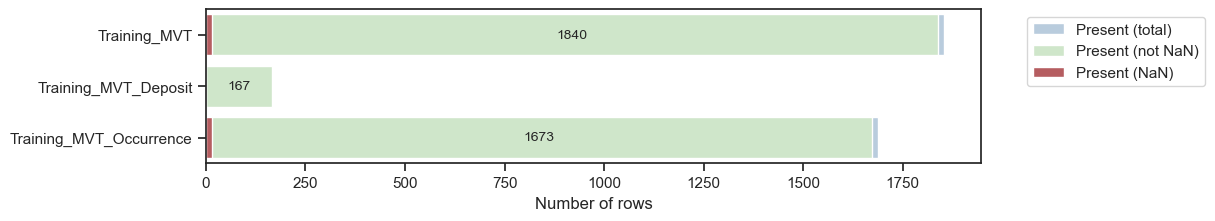

In [26]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
          
    # Plotting using Seaborn
    sns.set_theme(style="ticks")

    # Initialize the matplotlib figure
    fig, ax = plt.subplots(figsize=(10, 2))

    # Manually extract color codes for three bars
    colors = sns.color_palette("Pastel1", n_colors=len(COLS_GROUND_TRUTH))

    sns.barplot(x="Present total", y=df_nan_count.index, color=colors[1], data=df_nan_count, label="Present (total)")
    sns.barplot(x="Present not NaN", y=df_nan_count.index, color=colors[2], data=df_nan_count, label="Present (not NaN)")
    sns.barplot(x="Present NaN", y=df_nan_count.index, color="r", data=df_nan_count, label="Present (NaN)")

    # Adding labels and title
    plt.xlabel("Number of rows")
    
    # Annotate the not NaN values on each bar"
    for i, value in enumerate(df_nan_count["Present not NaN"]):
        ax.text(value - value/2, i, str(value), ha="center", va="center", fontsize=10)
    
    # Move the legend outside of the diagram
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show the plot
    plt.show();


# Investigate ground truth data

## **Numerical** columns

There are only few rows with NaN values within the **positive** ground truth data. These will be dropped for both the following analysis and training.<p>

For **inference**, NaN values will be imputed with an appropriate method to maintain the shape of the input data. <br>After inference, rows containing
 NaN values can be masked or replaced with a NoData value for raster export.

### Initial overview

Prepare data and **drop** rows containing NaN values

In [27]:
# Get rid of unncessary columns
model_columns_numerical = df.select_dtypes(include=np.number).columns.tolist()
df_model_numerical = df[[ground_truth_selected] + model_columns_numerical].copy()

# Drop rows with NaN values
df_model_numerical.dropna(how="any", inplace=True)


Overview for data (**unsplit**)

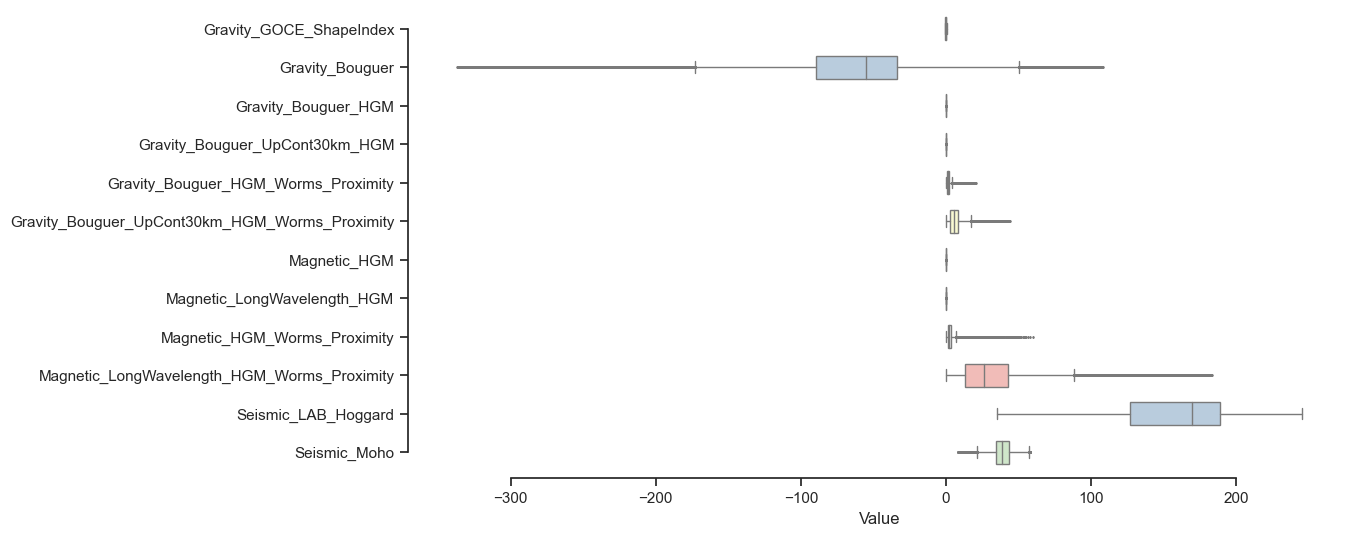

In [28]:
# Create correct dataframe shape
df_plot = pd.melt(df_model_numerical, id_vars=ground_truth_selected, var_name="Feature", value_name="Value")

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    sns.set_theme(style="ticks")
    fig, ax = plt.subplots(figsize=(12, 6))

    sns.boxplot(x="Value", y="Feature",
                palette=sns.color_palette("Pastel1"),
                linewidth=1,
                fliersize=1, dodge=True, width=0.6, whis=1.5,
                data=df_plot)
    
    ax.yaxis.label.set_visible(False)
    sns.despine(offset=5, trim=True)
    
    plt.plot();

Create overview for **Absent** and **Present** data 

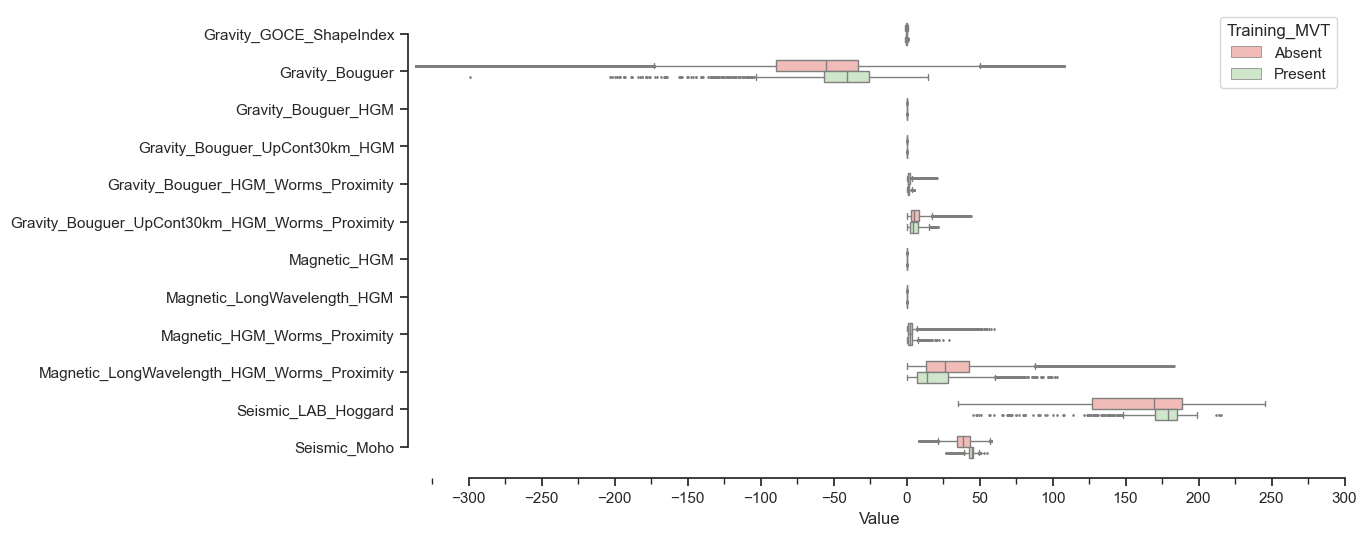

In [29]:
# Create correct dataframe shape
df_plot = pd.melt(df_model_numerical, id_vars=[ground_truth_selected], var_name="Feature", value_name="Value")

sns.set_theme(style="ticks")
sns.color_palette("Pastel1")

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = sns.color_palette("Pastel1", n_colors=3)

    sns.boxplot(x="Value", y="Feature",
                hue=ground_truth_selected, palette=[colors[0], colors[2]], linewidth=1,
                fliersize=1, dodge=True, width=0.6, whis=1.5,
                data=df_plot)
    
    ax.set_xlim(df_plot["Value"].min(), 300)                        # There are some outliers that make the plot unreadable, even above 1.000 (when using data with NaN values)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(25))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.yaxis.label.set_visible(False)
    
    sns.despine(offset=5, trim=True)
    
    plt.plot();

Investigate only **positive** ground truth values

In [30]:
# Get descriptive statistics for each feature
ground_truth_numerical_positives = df_model_numerical[df_model_numerical[ground_truth_selected] == "Present"][model_columns_numerical]
numerical_stats = ground_truth_numerical_positives.describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]).T
numerical_stats = numerical_stats.rename(columns=lambda x: x.capitalize())


In [31]:
# Append outlier information
for column in model_columns_numerical:
  lower_bound, upper_bound, outliers = eda.get_outliers_iqr(ground_truth_numerical_positives[column])
  
  numerical_stats.loc[column, "Lower bound"] = lower_bound
  numerical_stats.loc[column, "Upper bound"] = upper_bound
  numerical_stats.loc[column, "Outlier count"] = len(outliers)
  
# Outlier percentage
numerical_stats["Outlier %"] = round((numerical_stats["Outlier count"] / numerical_stats["Count"]) * 100, 2)
  

In [32]:
# View the statistics
numerical_stats

,Count,Mean,Std,Min,5%,10%,25%,50%,75%,90%,95%,Max,Lower bound,Upper bound,Outlier count,Outlier %
Gravity_GOCE_ShapeIndex,1840.000,-0.165,0.406,-0.844,-0.607,-0.598,-0.458,-0.244,0.027,0.446,0.824,0.949,-1.184,0.753,129.000,7.010
Gravity_Bouguer,1840.000,-45.958,34.238,-298.849,-114.837,-84.049,-56.845,-40.607,-25.439,-10.781,-5.874,14.658,-103.954,21.670,113.000,6.140
Gravity_Bouguer_HGM,1840.000,0.001,0.000,0.000,0.000,0.000,0.000,0.001,0.001,0.001,0.001,0.003,-0.000,0.002,69.000,3.750
Gravity_Bouguer_UpCont30km_HGM,1840.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,-0.000,0.000,69.000,3.750
Gravity_Bouguer_HGM_Worms_Proximity,1840.000,1.374,0.854,0.000,0.250,0.414,0.740,1.208,1.889,2.483,2.893,5.398,-0.985,3.614,37.000,2.010
Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity,1840.000,5.392,4.048,0.000,0.618,1.031,2.237,4.458,7.606,11.183,13.032,21.610,-5.816,15.659,36.000,1.960
Magnetic_HGM,1840.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,69.000,3.750
Magnetic_LongWavelength_HGM,1840.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,145.000,7.880
Magnetic_HGM_Worms_Proximity,1840.000,3.099,2.857,0.387,0.707,0.830,1.246,2.209,3.812,6.699,8.701,28.762,-2.604,7.662,132.000,7.170
Magnetic_LongWavelength_HGM_Worms_Proximity,1840.000,21.058,20.114,0.006,1.332,2.611,7.133,13.729,28.427,50.156,66.165,103.379,-24.808,60.369,119.000,6.470


# Distribution
## With outliers

In [33]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
        
    # Determine the number of rows and columns for subplots
    n_cols = 4
    n_rows = -(-len(model_columns_numerical) // n_cols)  # Round up division

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3 * n_rows))
    fig.subplots_adjust(wspace=0.5, hspace=0.5) 

    # Plot the distribution of each selected column
    for i, column in enumerate(model_columns_numerical):
        row, col = divmod(i, n_cols)

        # If there's only one row, treat axes as 1D array
        if n_rows == 1:
            ax = axes[col]
        else:
            ax = axes[row, col]

        values = df[column].values
        values = values[~np.isnan(values)]
        
        sns.histplot(values, kde=True, bins=20, color='skyblue', ax=ax)
        ax.set_xlabel(column)
        ax.set_ylabel("Frequency")

    # Remove empty subplots if any
    if len(model_columns_numerical) % n_cols != 0:
        for i in range(len(model_columns_numerical) % n_cols, n_cols):
            if n_rows == 1:
                fig.delaxes(axes[i])
            else:
                fig.delaxes(axes[-1, i])

    plt.show()

## Outlier-corrected

In [ ]:
df_outlier_correction = df_model_numerical.copy()

for column in model_columns_numerical:
    lower_bound, upper_bound, outliers = eda.get_outliers_iqr(df_outlier_correction[column])
    
    df_outlier_correction.loc[df_outlier_correction[column] < lower_bound, column] = lower_bound
    df_outlier_correction.loc[df_outlier_correction[column] > upper_bound, column] = upper_bound
  

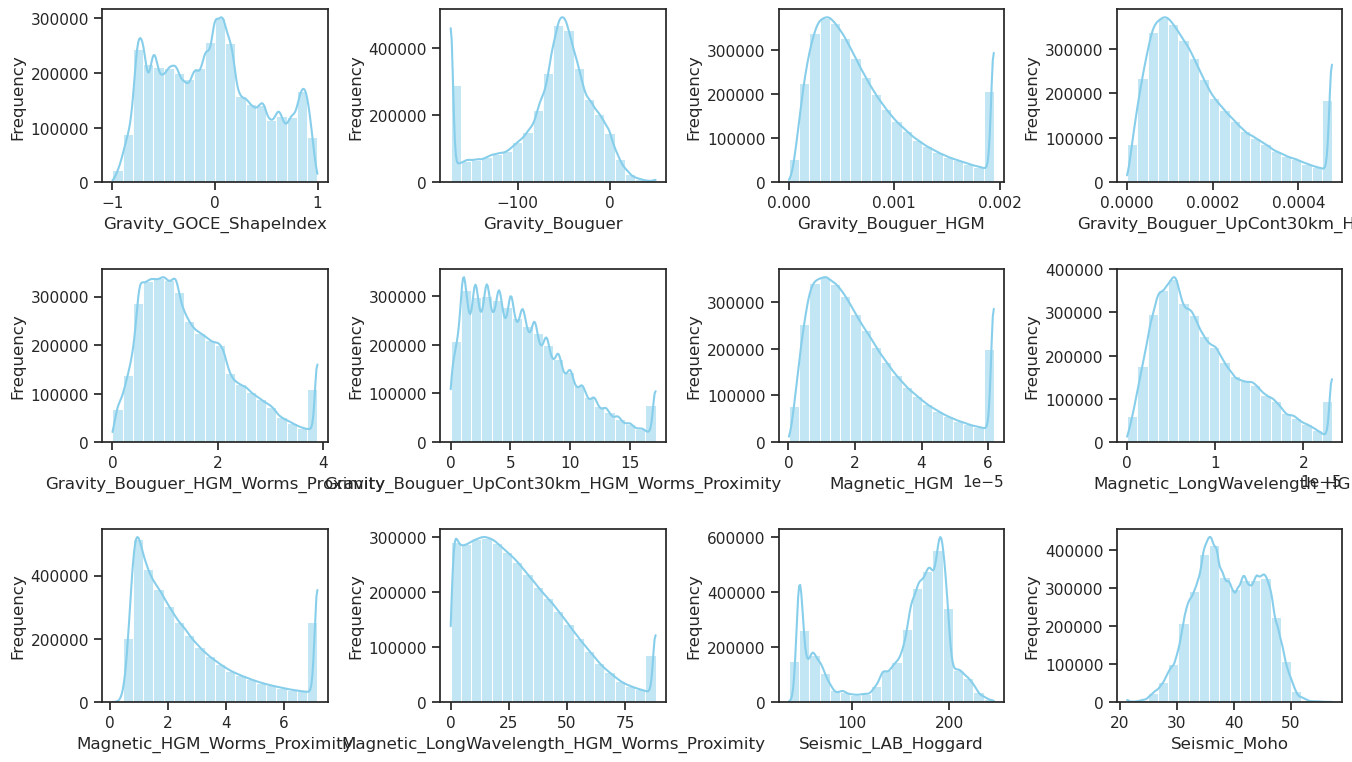

In [ ]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
        
    # Determine the number of rows and columns for subplots
    n_cols = 4
    n_rows = -(-len(model_columns_numerical) // n_cols)  # Round up division

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3 * n_rows))
    fig.subplots_adjust(wspace=0.5, hspace=0.5) 

    # Plot the distribution of each selected column
    for i, column in enumerate(model_columns_numerical):
        row, col = divmod(i, n_cols)

        # If there's only one row, treat axes as 1D array
        if n_rows == 1:
            ax = axes[col]
        else:
            ax = axes[row, col]

        values = df_outlier_correction[column].values
        values = values[~np.isnan(values)]
        
        sns.histplot(values, kde=True, bins=20, color='skyblue', ax=ax)
        ax.set_xlabel(column)
        ax.set_ylabel("Frequency")

    # Remove empty subplots if any
    if len(model_columns_numerical) % n_cols != 0:
        for i in range(len(model_columns_numerical) % n_cols, n_cols):
            if n_rows == 1:
                fig.delaxes(axes[i])
            else:
                fig.delaxes(axes[-1, i])

    plt.show()